# Massey Sport Ranking

Massey ranking method is a twist of one of the simplest method of ranking: the goal difference. Massey’s method assigns ratings for each team, which we can use to rank those teams.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')

In [2]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 400
from highlight_text import fig_text

body_font = "Open Sans"
watermark_font = "DejaVu Sans"
text_color = "w"
background = "#282B2F"
title_font = "DejaVu Sans"

mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
mpl.rcParams['text.color'] = text_color
mpl.rcParams['axes.edgecolor'] = text_color
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 6

In [3]:
fixtures = pd.read_csv(
    '../data/fpl_official/vaastav/data/2021-22/fixtures.csv')

league_table = pd.read_csv(
    '../data/fpl_official/vaastav/data/2021-22/teams.csv'
    )[['id', 'name', 'short_name']]

In [4]:
league_table = league_table.replace({
    'Brighton': 'Brighton and Hove Albion',
    'Leicester': 'Leicester City',
    'Leeds': 'Leeds United',
    'Man City': 'Manchester City',
    'Man Utd': 'Manchester United',
    'Norwich': 'Norwich City',
    'Spurs': 'Tottenham Hotspur',
    'West Ham': 'West Ham United',
    'Wolves': 'Wolverhampton'
})

In [5]:
logos = {
    # https://www.transfermarkt.com/premier-league/transfers/wettbewerb/GB1
    'Arsenal': '../data/logos/ARS.png',
    'Aston Villa': '../data/logos/AVL.png',
    'Brighton and Hove Albion': '../data/logos/BHA.png',
    'Brentford': '../data/logos/BRE.png',
    'Burnley': '../data/logos/BUR.png',
    'Chelsea': '../data/logos/CHE.png',
    'Crystal Palace': '../data/logos/CRY.png',
    'Everton': '../data/logos/EVE.png',
    'Leicester City': '../data/logos/LEI.png',
    'Leeds United': '../data/logos/LEE.png',
    'Liverpool': '../data/logos/LIV.png',
    'Manchester City': '../data/logos/MCI.png',
    'Manchester United': '../data/logos/MUN.png',
    'Norwich City': '../data/logos/NOR.png',
    'Newcastle': '../data/logos/NEW.png',
    'Southampton': '../data/logos/SOU.png',
    'Tottenham Hotspur': '../data/logos/TOT.png',
    'Watford': '../data/logos/WAT.png',
    'West Ham United': '../data/logos/WHU.png',
    'Wolverhampton': '../data/logos/WOL.png',
}

In [6]:
from massey import Massey

massey = Massey(fixtures, league_table)
lt = massey.rating().sort_values('massey')

In [7]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def get_logo(name):
    return plt.imread(logos[name])

def offset_image(coord, name, ax):
    img = get_logo(name)
    im = OffsetImage(img, zoom=0.20)
    im.image.axes = ax

    ab = AnnotationBbox(
        im,
        (-0.05, (coord+1.3)/21.7),
        frameon=False, xycoords='axes fraction')

    ax.add_artist(ab)

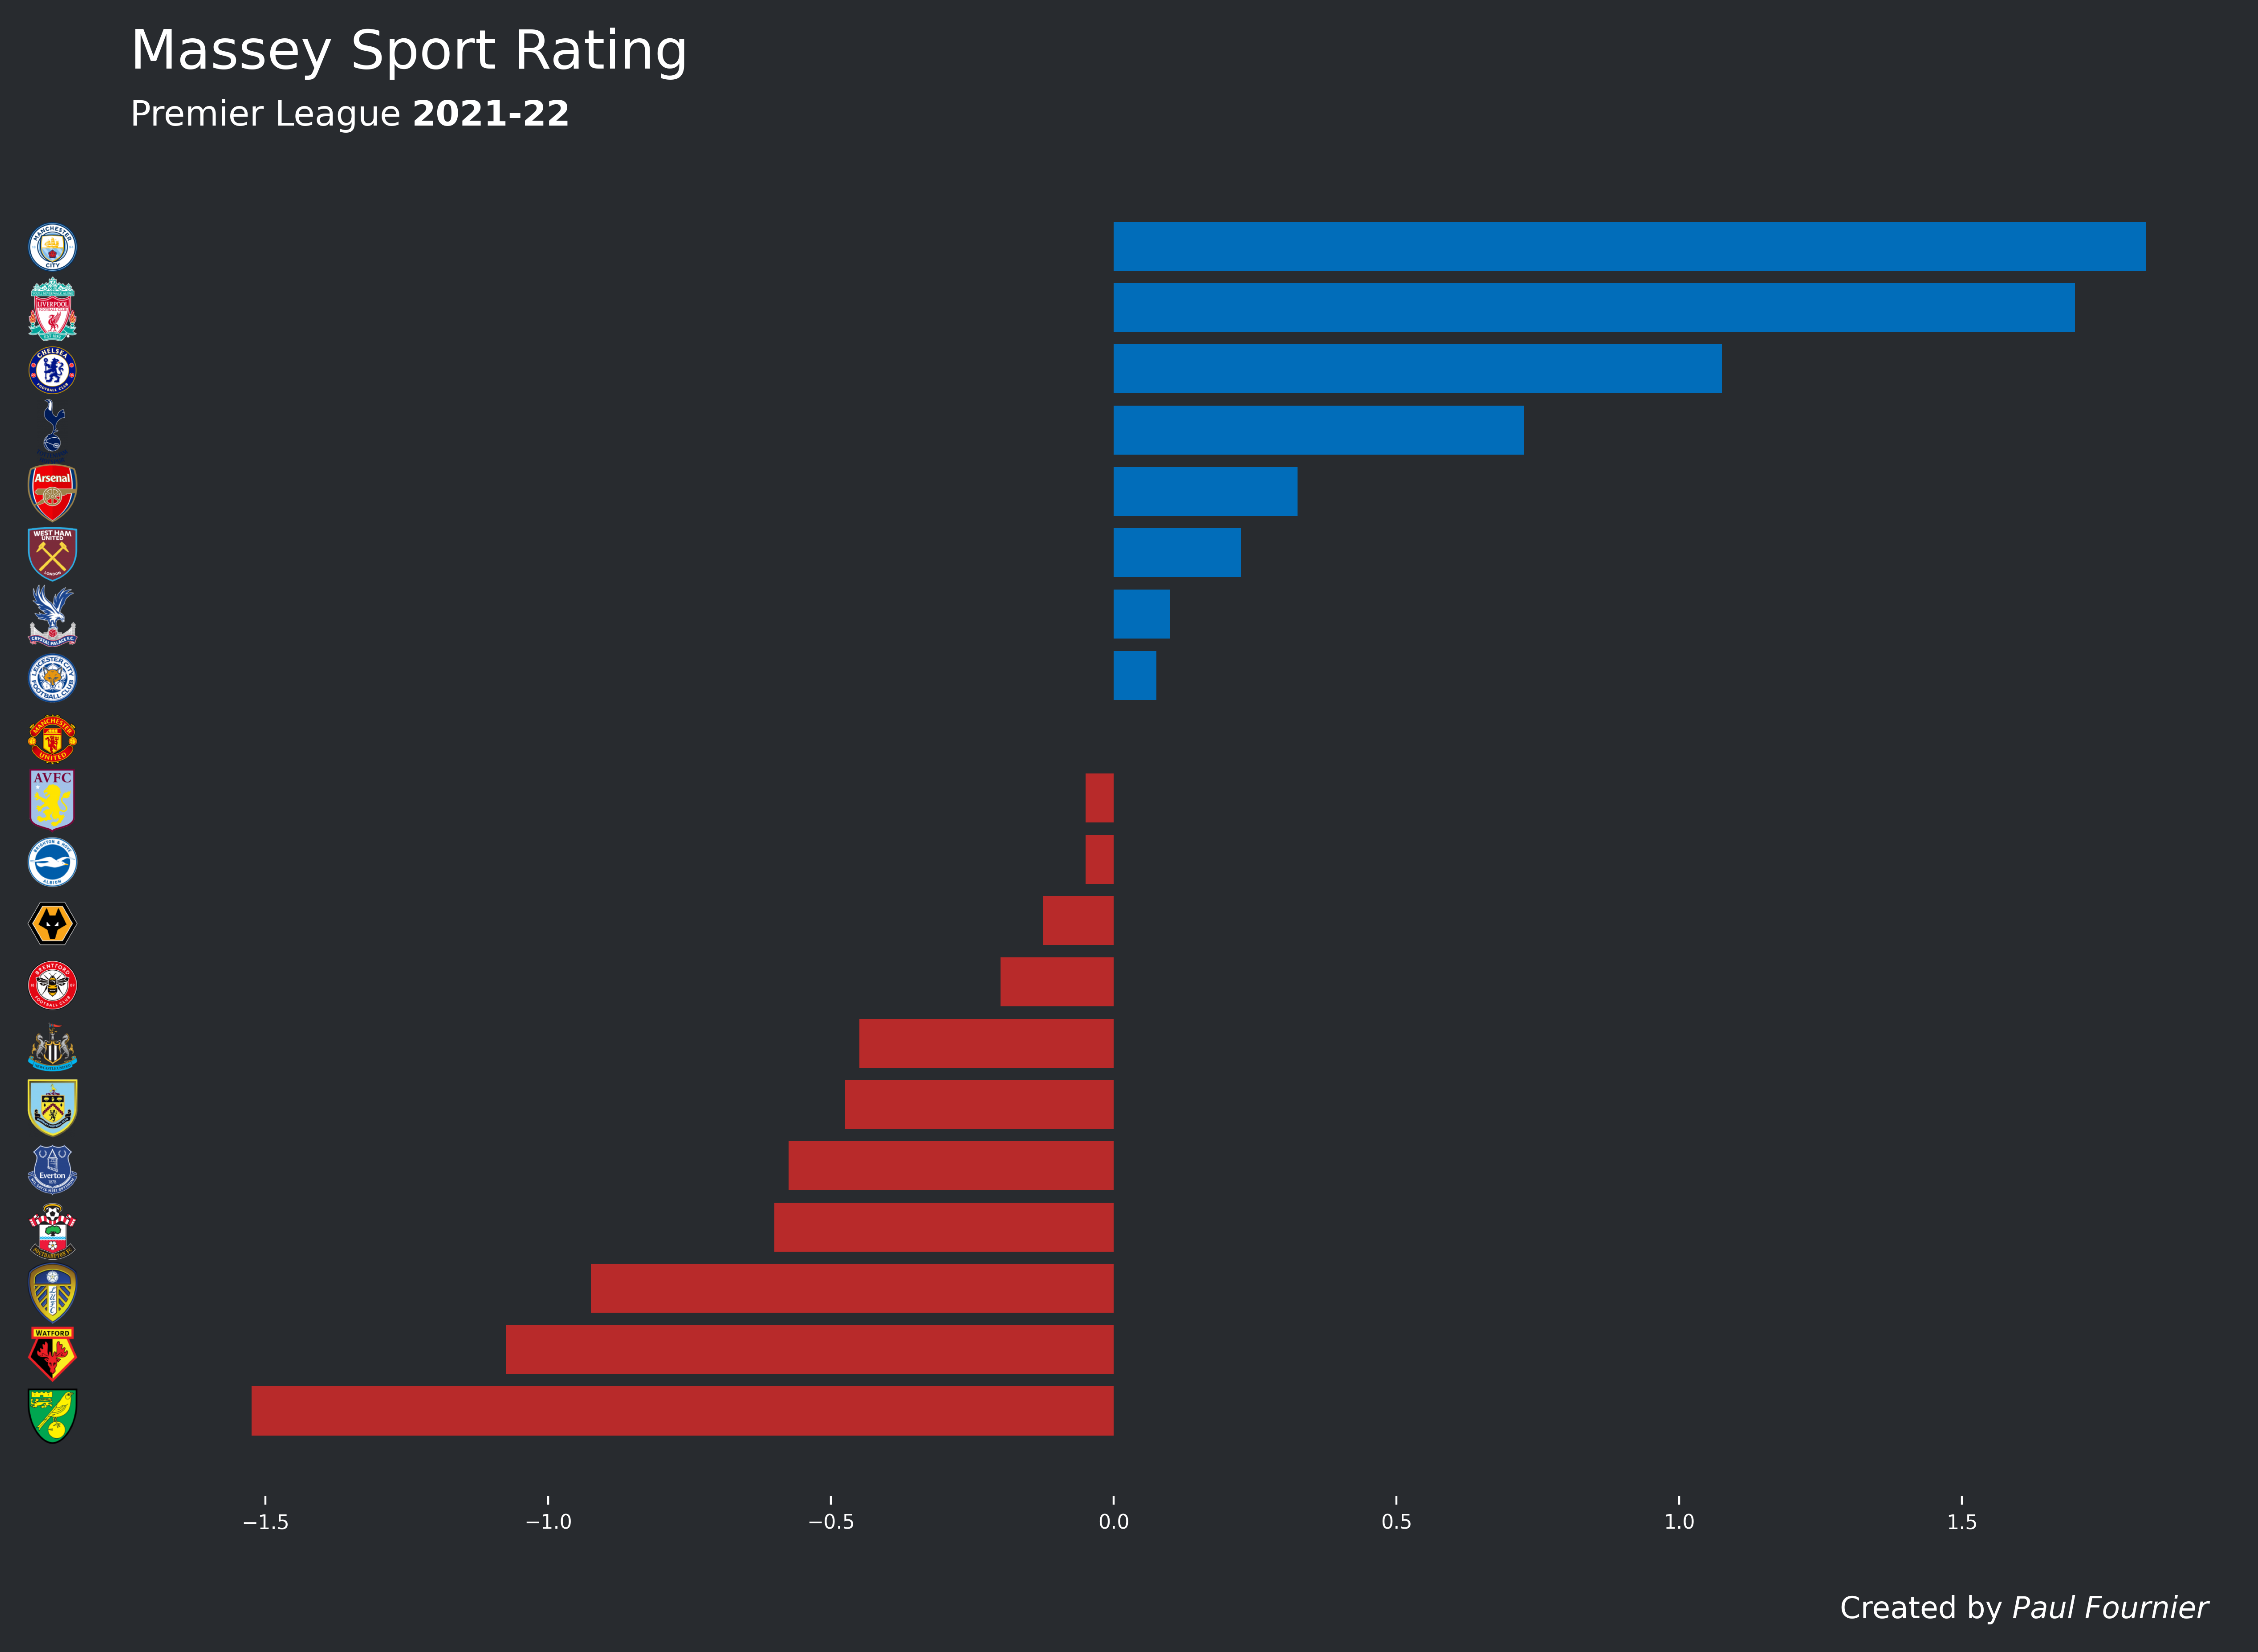

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

for i, c in enumerate(lt['name']):
    offset_image(i, c, ax)

ax.barh(
    lt['name'],
    lt['massey'],
    color=[
        "#016DBA" if val > 0 else "#B82A2A" 
        for val in lt['massey'].values])

ax.get_yaxis().set_visible(False)
plt.box(on=None)

fig_text(
    x=0., y=1.075,
    s="Massey Sport Rating",
    fontsize=22, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0., y=1.025,
    s="Premier League <2021-22>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=14, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=-0.025,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=12, fontfamily=watermark_font,
    color=text_color)

plt.tight_layout()
plt.show()

To validate the results, the average of all the ratings should be equal: $0$ (or at least close to since we evaluate ratings with least squares).

In [9]:
np.mean(lt.massey)

8.770761894538737e-16

## Weighted Massey Ranking

In [10]:
massey = Massey(fixtures, league_table, decay=True)
lt = massey.rating().sort_values('massey')

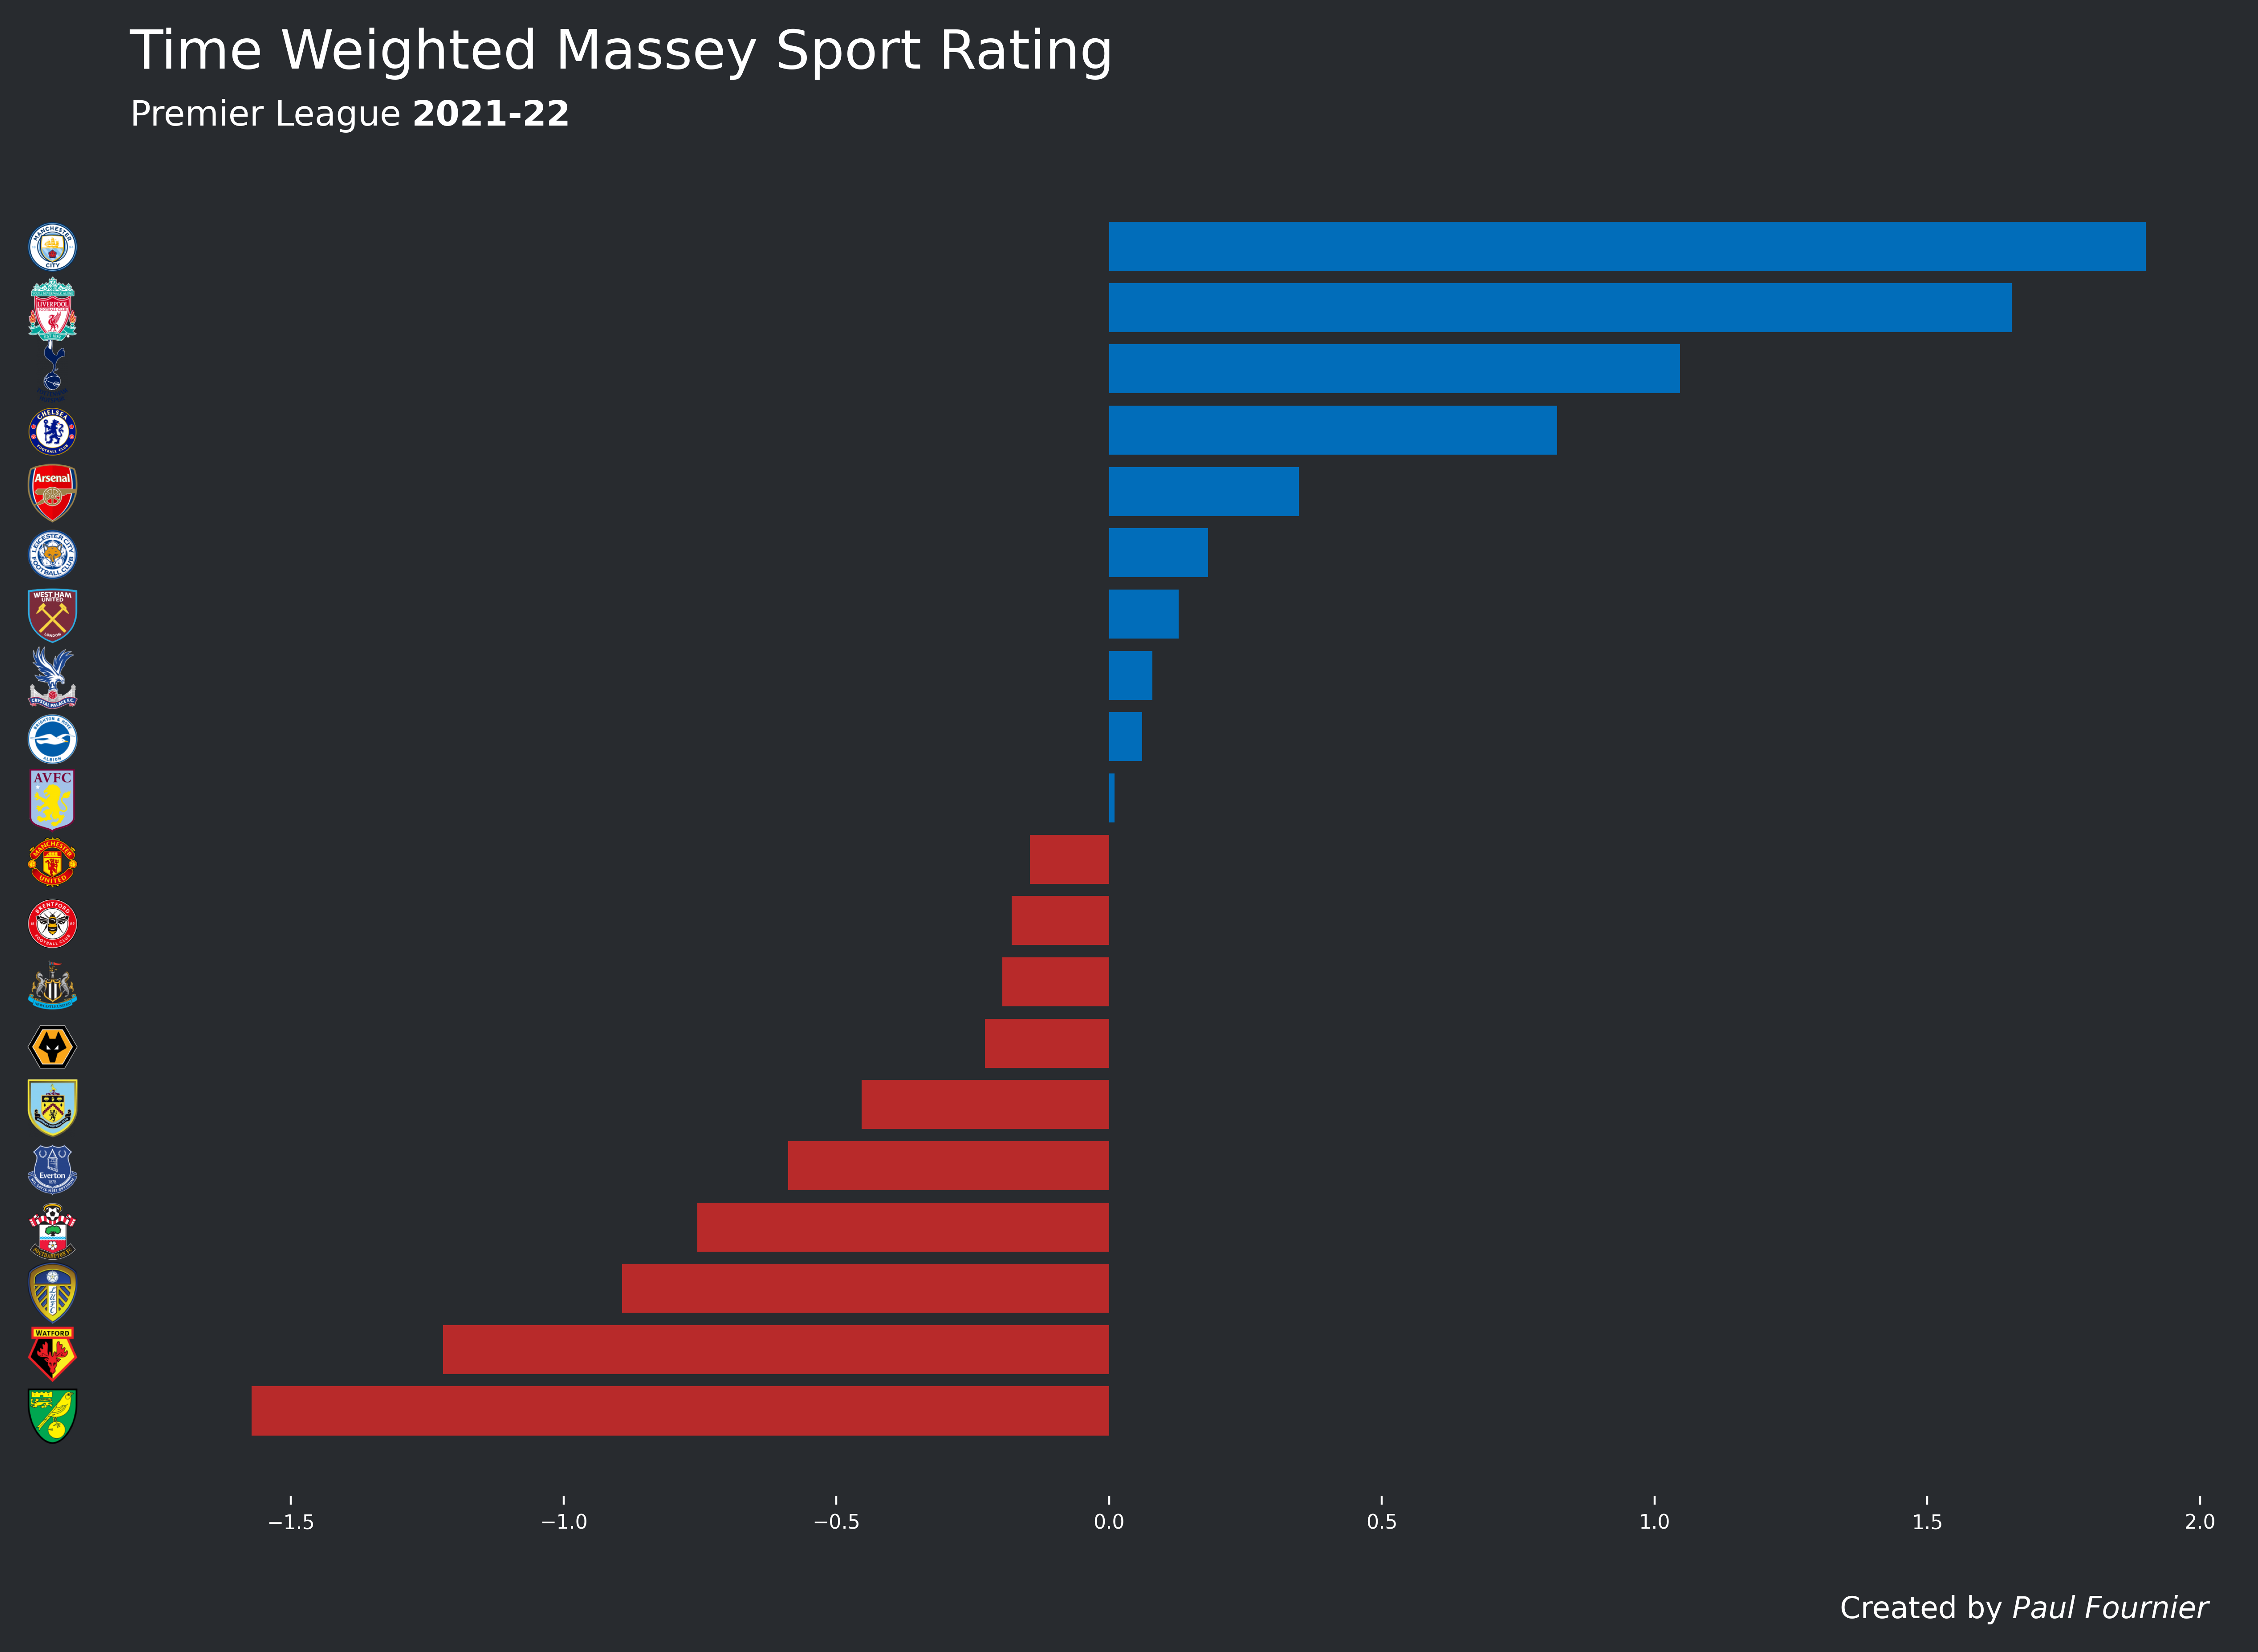

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

for i, c in enumerate(lt['name']):
    offset_image(i, c, ax)

ax.barh(
    lt['name'],
    lt['massey'],
    color=[
        "#016DBA" if val > 0 else "#B82A2A"
        for val in lt['massey'].values ])

ax.get_yaxis().set_visible(False)
plt.box(on=None)

fig_text(
    x=0., y=1.075,
    s="Time Weighted Massey Sport Rating",
    fontsize=22, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0., y=1.025,
    s="Premier League <2021-22>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=14, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=-0.025,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=12, fontfamily=watermark_font,
    color=text_color)

plt.tight_layout()
plt.show()

Once again, the average of all the ratings should be equal: $0$.

In [12]:
np.mean(lt.massey)

-1.0103029524088924e-15

## Offensive & Defensive Ratings

After some math wizardry with the Massey equations (found [here](https://datascience.oneoffcoder.com/massey-method-ii.html)), we can get offensive and defensive ratings for each team.

In [13]:
massey = Massey(fixtures, league_table)
lt = massey.offensive_defensive().sort_values('o')

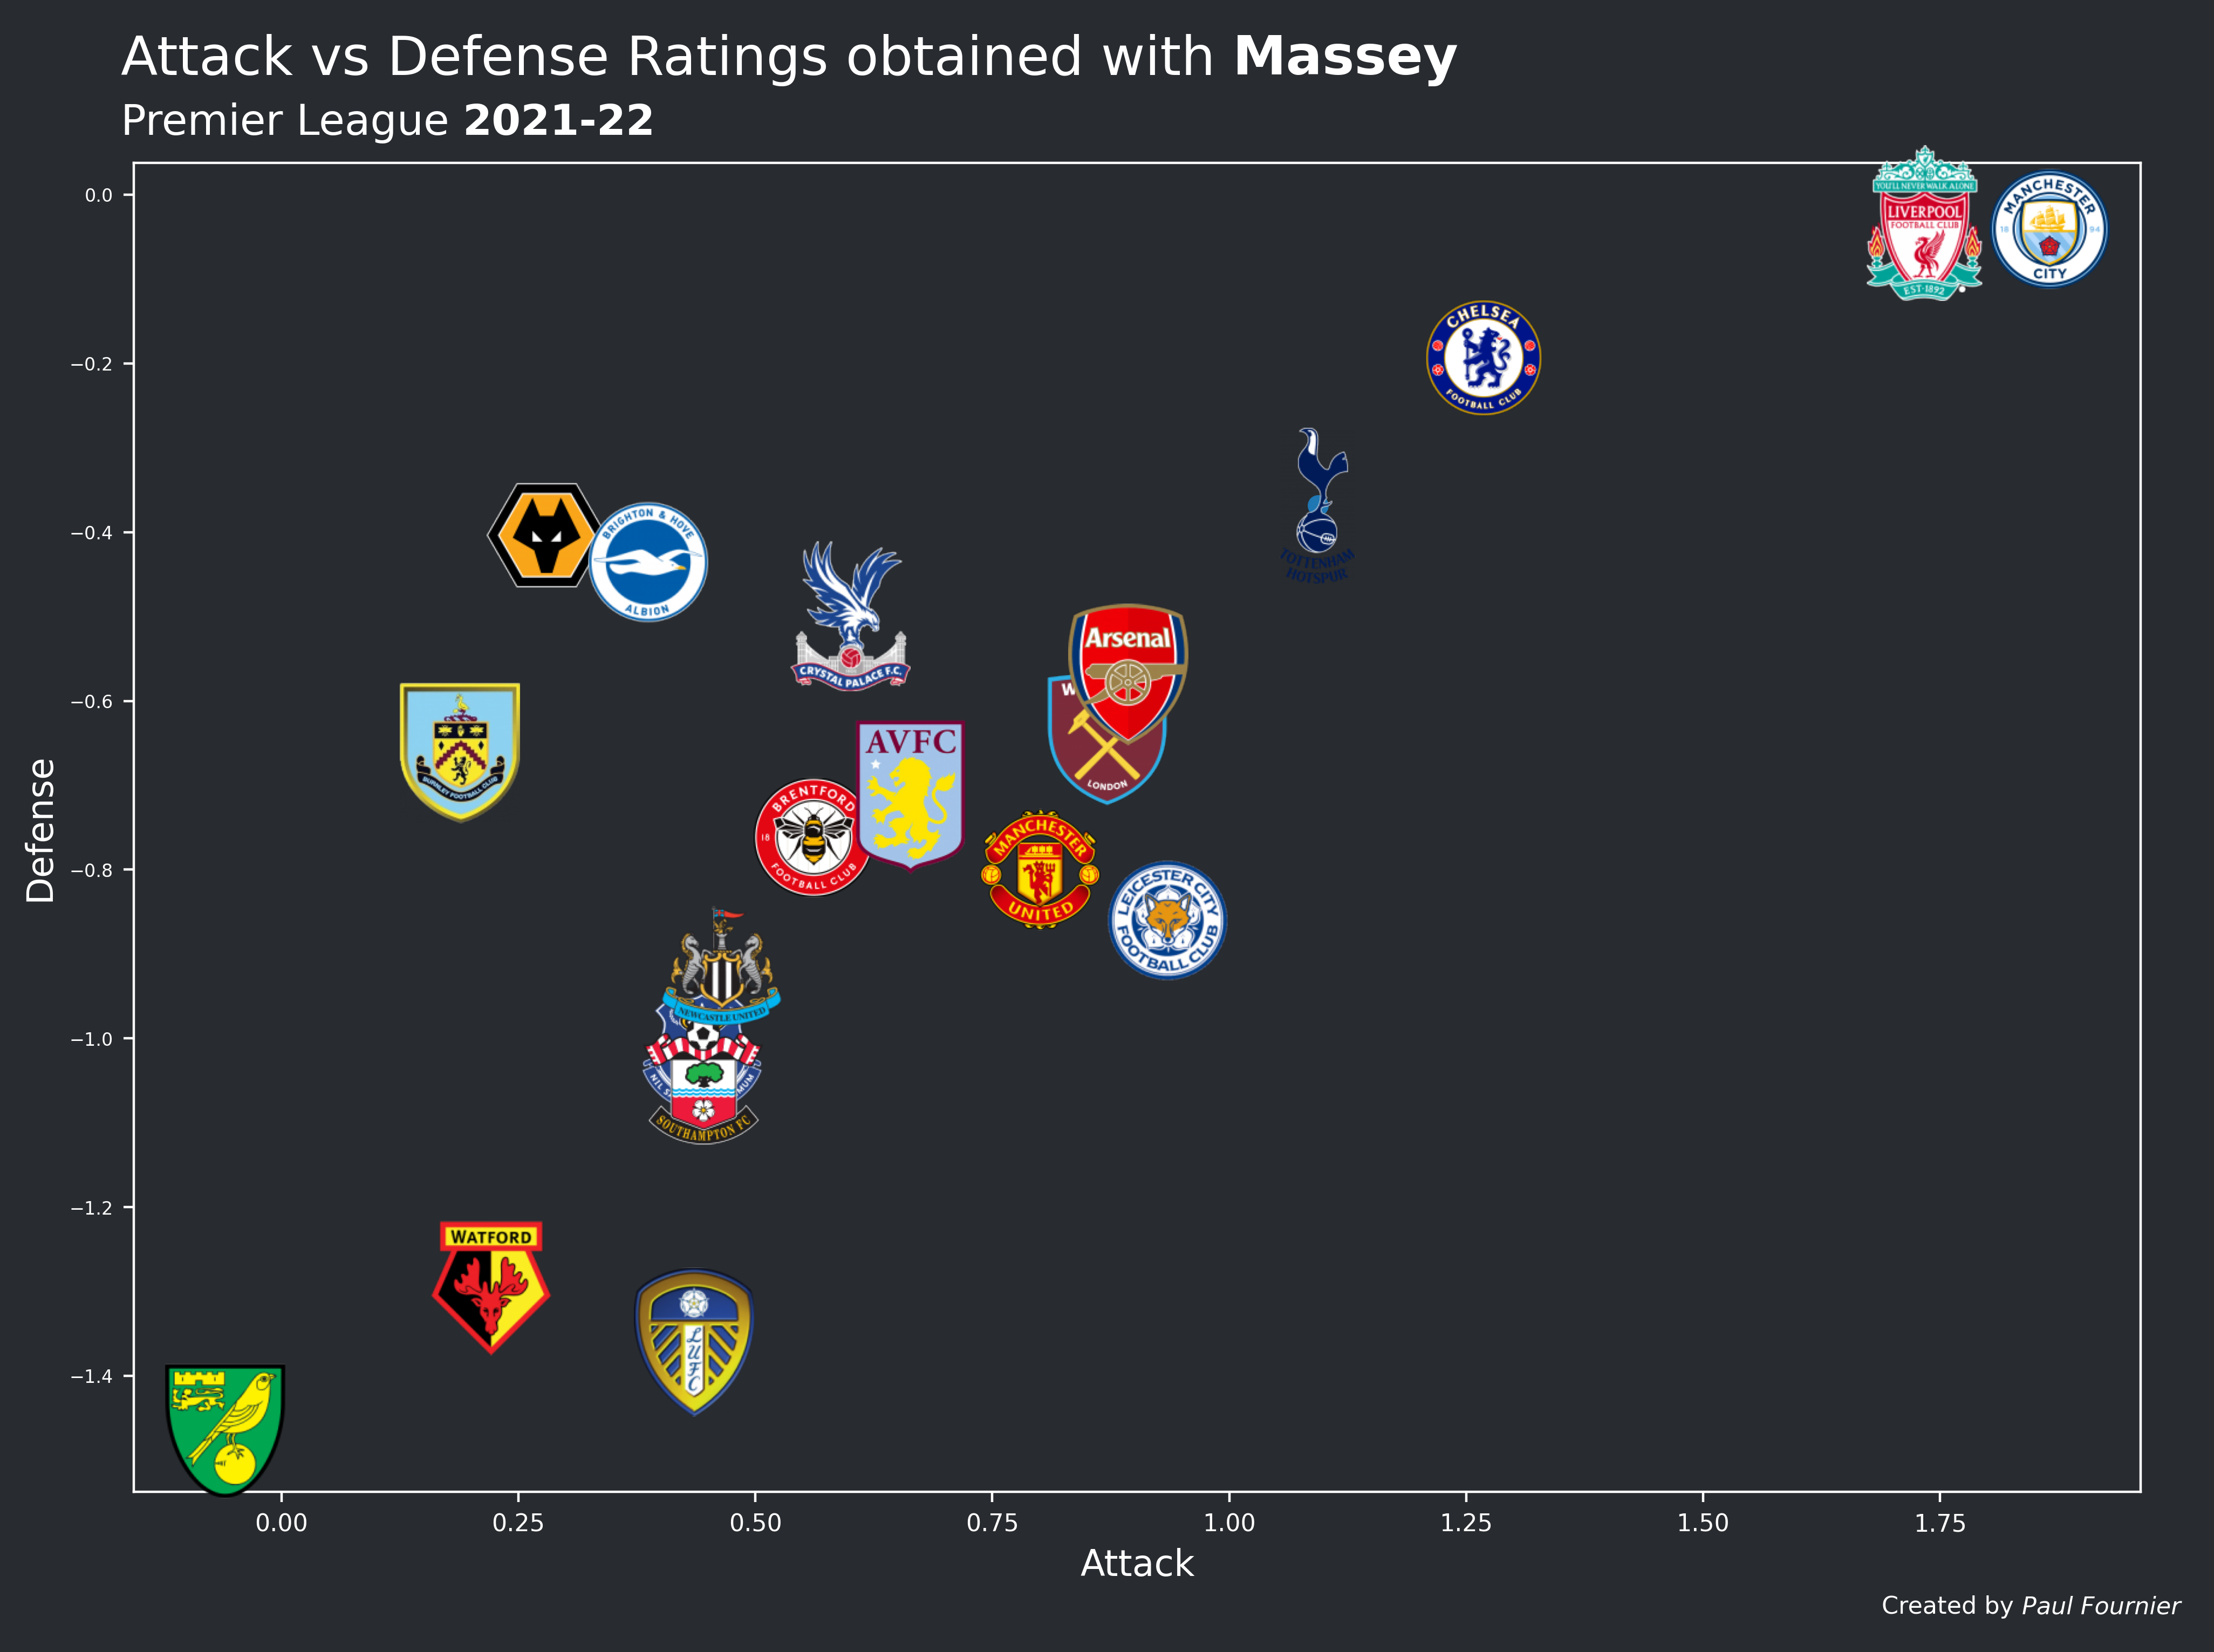

In [14]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(path):
    return OffsetImage(plt.imread(path), zoom = 0.4)

fig, ax = plt.subplots(figsize=(12, 8))
fig.set_facecolor(background)
ax.patch.set_alpha(0)

ax.plot(lt.o, lt.d, 'o')

for label, x, y in zip(lt.name, lt.o, lt.d):
    if label in logos.keys():
        ab = AnnotationBbox(
            getImage(logos[label]),
            (x, y),
            frameon=False)
        ax.add_artist(ab)

fig_text(
    x=0.12, y=0.955,
    s="Attack vs Defense Ratings obtained with <Massey>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=18, fontfamily=title_font, color=text_color, alpha=1)
fig_text(
    x=0.12, y=0.915,
    s="Premier League <2021-22>",
    highlight_textprops=[{"fontweight": "bold"}],
    fontsize=14, fontfamily=title_font, color=text_color, alpha=1)

fig_text(
    x=0.8, y=0.05,
    s="Created by <Paul Fournier>",
    highlight_textprops=[{"fontstyle": "italic"}],
    fontsize=8, fontfamily=watermark_font, color=text_color)

ax.set_xlabel('Attack', fontsize=12, color=text_color)
ax.set_ylabel('Defense' , fontsize=12, color=text_color)

plt.show()